    Ben Christensen
    Math 323
    2/19/18

Code quasi-newton methods and use them to solve optimization problems.

In [1]:
import numpy as np
from scipy import linalg as la
from time import time
from scipy import optimize as opt
from matplotlib import pyplot as plt

In [2]:
#Rosenbrock function and derivatives
def f(x):
    return 100*(x[1] - x[0]**2)**2 + (1 - x[0])**2

def Df(x):
    return np.array([400*x[0]*(x[0]**2 - x[1]) + 2*x[0] - 2, -200*x[0]**2 + 200*x[1]])

def D2f(x):
    return np.array([[1200*x[0]**2 - 400*x[1] + 2, -400*x[0]],
                        [-400*x[0], 200]])
# Problem 1
def newton(Df, D2f, x0, maxiter=20, tol=1e-5):
    """Use Newton's method to minimize a function f:R^n -> R.

    Parameters:
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        D2f (function): The second dirivative (Hessian) of f. Accepts a NumPy
            array of shape (n,) and returns a NumPy array of shape (n,n).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate optimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    xk = x0
    iters = 0
    converged = False
    #Implement Newton's Method
    for k in range(maxiter):
        first_deriv = Df(xk)
        zk = la.solve(D2f(xk), first_deriv)
        xk1 = xk - zk
        iters += 1
        if np.max(np.abs(first_deriv)) < tol:
            converged = True
            break
        xk = xk1

    return xk1, converged, iters


# Problem 2
def bfgs(Df, x0, maxiter=80, tol=1e-5):
    """Use BFGS to minimize a function f:R^n -> R.

    Parameters:
        Df (function): The first derivative of f. Accepts and returns a NumPy
            array of shape (n,).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate optimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    n = len(x0)
    A_k = np.eye(n,n)
    xk = x0
    xk1 = xk / 2
    iters = 0
    #Initialize deriv_2 so we only have to calc. it once in the loop: (check recursive step)
    deriv_2 = Df(xk)
    converged = False
    for k in range(int(maxiter / 2)):
        #We're going to code the alg. twice in one loop to account for the
        #two xk+1 and xk needed in the algorithm
        #Use BFGS the first time:
        sk = xk1 - xk
        deriv_1 = deriv_2
        deriv_2 = Df(xk1)
        yk = deriv_2.T - deriv_1.T
        styk = sk @ yk
        if styk == 0:
            break
        #BFGS
        A_k = A_k + (styk + yk.T@A_k@yk)*np.outer(sk, sk) / styk**2 - (np.outer(A_k@yk, sk) + np.outer(sk, yk.T@A_k)) / styk
        new_x = xk1 - A_k@deriv_2
        iters += 1
        new_deriv = Df(new_x)
        if np.max(np.abs(new_deriv)) < tol:
            converged = True
            break
        #Do BFGS a second time
        xk = new_x
        sk = xk - xk1
        deriv_1 = deriv_2
        deriv_2 = new_deriv
        yk = deriv_2.T - deriv_1.T
        styk = sk @ yk
        if styk == 0:
            break
        #BFGS
        A_k = A_k + (styk + yk.T@A_k@yk)*np.outer(sk, sk) / styk**2 - (np.outer(A_k@yk, sk) + np.outer(sk, yk.T@A_k)) / styk
        new_x = xk - A_k@deriv_2
        iters += 1
        new_deriv = Df(new_x)
        if np.max(np.abs(new_deriv)) < tol:
            converged = True
            break
        xk1 = new_x

    return new_x, converged, iters



# Problem 3
def prob3(N=100):
    """Compare newton(), bfgs(), and scipy.optimize.fmin_bfgs() by repeating
    the following N times.
        1. Sample a random initial guess x0 from the 2-D uniform distribution
            over [-3,3]x[-3,3].
        2. Time (separately) newton(), bfgs(), and scipy.optimize.bfgs_fmin()
            for minimizing the Rosenbrock function with an initial guess of x0.
        3. Record the number of iterations from each method.
    Plot the computation times versus the number of iterations with a log-log
    scale, using different colors for each method.
    """
    N_iterations = []
    N_times = []
    B_iterations = []
    B_times = []
    S_iterations = []
    S_times = []
    for i in range(N):
        #Random 2-d starting point on [-3, 3] x [-3, 3]
        x0 = np.random.uniform(-3, 3, 2)
        #Timing Newton method
        start = time()
        iterations = newton(Df, D2f, x0)
        end = time()
        N_iterations.append(iterations[2])
        N_times.append(end - start)
        #Timing BFGS method
        start = time()
        iterations = bfgs(Df, x0)
        end = time()
        B_iterations.append(iterations[2])
        B_times.append(end - start)
        #Timing Scipy Method
        start = time()
        iterations = opt.fmin_bfgs(f, x0, Df, disp=False, retall=True)
        end = time()
        S_iterations.append(len(iterations[1]))
        S_times.append(end - start)
    #Plot times against iterations on log-log scale
    plt.scatter(N_times, N_iterations, alpha=.5, label="Newton's method")
    plt.scatter(B_times, B_iterations, alpha = .5, label="BFGS")
    plt.scatter(S_times, S_iterations, alpha = .5, label="scipy.optimize.fmin_bfgs()")
    plt.legend(loc="upper left")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Iterations")
    plt.show()



# Problem 4
def gauss_newton(J, r, x0, maxiter=10, tol=1e-5):
    """Solve a nonlinear least squares problem with the Gauss-Newton method.

    Parameters:
        J (function): Jacobian of the residual function. Accepts a NumPy array
            of shape (n,) and returns a NumPy array of shape (m,n).
        r (function): Residual vector function. Accepts a NumPy array of shape
            (n,) and returns an array of shape (m,).
        x0 ((n,) ndarray): The initial guess.
        maxiter (int): The maximum number of iterations to compute.
        tol (float): The stopping tolerance.

    Returns:
        ((n,) ndarray): The approximate optimizer of f.
        (bool): Whether or not the algorithm converged.
        (int): The number of iterations computed.
    """
    xk = x0
    iters = 0
    converged = False
    T = np.arange(10)
    for k in range(maxiter):
        yk = la.solve(J(xk).T@J(xk), J(xk).T@r(xk))
        xk1 = xk - yk
        iters += 1
        if la.norm(xk1 - xk) < tol:
            converged = True
            break
        xk = xk1

    return xk1, converged, iters



# Problem 5
def prob5(filename="/Users/benchristensen/Desktop/ACME Python Labs/Volume2-Student-Materials/QuasiNewton/population.npy"):
    """Load the data from the given file. Fit the data to an exponential model

        phi(x1, x2, x3, t) = x1 exp(x2(t + x3))

    and to a logistic model

        phi(x1, x2, x3, t) = x1 / (1 + exp(-x2(t + x3))).

    Plot the resulting curves along with the data points.
    """
    data = np.load(filename)
    x0 = np.array([1.5, .4, 2.5])
    T = data[:,0]
    y = data[:,1]
    #Use Non-linear least squares on the data using an exponential model
    model = lambda x, t: x[0]*np.exp(x[1]*(t + x[2]))
    residual = lambda x: model(x, T) - y
    jac = lambda x: np.column_stack((np.exp(x[1]*(T+x[2])), x[0]*(T+x[2])*np.exp(x[1]*(T+x[2])), x[0]*x[1]*np.exp(x[1]*(T+x[2]))))
    #ans = gauss_newton(jac, residual, x0)[0]
    ans = opt.leastsq(func=residual, x0=x0, Dfun = jac)[0]
    plt.plot(ans[0]*np.exp(ans[1]*(T+ans[2])), label="exp model")
    #Using the Logistic Model
    x0 = np.array([150, .4, -15])
    model = lambda x, t: x[0] / (1 + np.exp(-x[1]*(t + x[2])))
    residual = lambda x: model(x, T) - y
    jac = lambda x: np.column_stack((np.exp(x[1]*(T + x[2])) / (np.exp(x[1]*(T + x[2])) + 1),
                                    x[0]*(T + x[2])*np.exp(x[1]*(T + x[2])) / (np.exp(x[1]*(T + x[2])) + 1)**2,
                                    x[0]*x[1]*np.exp(x[1]*(T+x[2])) / (np.exp(x[1] * (T + x[2])) + 1)**2
                                    ))
    ans = opt.leastsq(func=residual, x0=x0, Dfun = jac)[0]
    #Plot the graphs together
    plt.plot(ans[0]/ (1 + np.exp(-ans[1]*(T+ans[2]))), label="logistic model")
    plt.scatter(T, y, label="data")
    plt.xlabel("Year")
    plt.ylabel("Population")
    plt.title("Population Growth")
    plt.legend(loc="upper left")
    plt.show()


In [3]:
#Test problem 1 using the Rosenbrock function
x0 = np.array([-2, 2])
print("Newton method:", newton(Df, D2f, x0))
#Test problem 2
print("BFGS:", bfgs(Df, x0, maxiter=100))
#Test prob4
x0 = np.array([2.5, .6])
T = np.arange(10)
y = 3*np.sin(0.5*T)+ 0.5*np.random.randn(10)
model = lambda x, t: x[0]*np.sin(x[1]*t)
residual = lambda x: model(x, T) - y
jac = lambda x: np.column_stack((np.sin(x[1]*T), x[0]*T*np.cos(x[1]*T)))
print("opt.leastsq():", opt.leastsq(func=residual, x0=x0, Dfun=jac))
print("Gauss newton method:", gauss_newton(jac, residual, x0))

Newton method: (array([ 1.,  1.]), True, 6)
BFGS: (array([ 1.00000001,  1.00000002]), True, 80)
opt.leastsq(): (array([ 3.35203203,  0.4944918 ]), 1)
Gauss newton method: (array([ 3.35203203,  0.4944918 ]), True, 5)


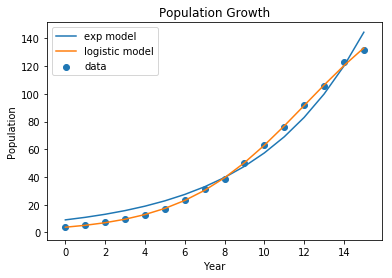

In [4]:
prob5()